# Load Dataset from ~/data


> Import libraries and set up source directories


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from random import randint
from skimage.transform import resize
from skimage import io, img_as_float, color
import seaborn as sns
import concurrent.futures
import pickle
import cv2
import gc


In [2]:
root = "../data"
labels = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
datapath = []
for label in labels:
    datapath.append(os.path.join(root, label))
datapath


['../data/Uninfected', '../data/Parasitized']

We have 2 classes of images: Uninfected and Parasitized. We will use the following labels for them:

- 0 for Uninfected
- 1 for Parasitized


> Utility Section


In [3]:
def load_image(path):
    """Wrapper function for skimage.io.imread parallelization
    The image is returned as a numpy array with shape (M, N, 3) and dtype uint8."""
    return io.imread(path, pilmode="RGB")


def load_image_bw(path):
    """Wrapper function for skimage.io.imread parallelization
    The image is returned as a numpy array with shape (M, N) and dtype uint8."""
    return io.imread(path, pilmode="L")

In [4]:
"""Commented to speed up the process"""
# We use concurrent.futures to speed up the process, since it is a CPU-bound task
uninf_path = [os.path.join(datapath[0], _) for _ in os.listdir(datapath[0])]
para_path = [os.path.join(datapath[1], _) for _ in os.listdir(datapath[1])]
with concurrent.futures.ProcessPoolExecutor() as executor:
    # uninf_args = [(path, resize_to) for path in uninf_path]
    # para_args = [(path, resize_to) for path in para_path]
    uninf_imgs = executor.map(load_image, uninf_path)
    para_imgs = executor.map(load_image, para_path)
# convert the map object to a list
uninf_imgs = list(uninf_imgs)
para_imgs = list(para_imgs)
with concurrent.futures.ProcessPoolExecutor() as executor:
    uninf_imgs_bw = executor.map(load_image_bw, uninf_path)
    para_imgs_bw = executor.map(load_image_bw, para_path)
uninf_imgs_bw = list(uninf_imgs_bw)
para_imgs_bw = list(para_imgs_bw)


> Display sample images

We want to see some images to get a feel for the data and to make sure that the data is loaded correctly. We also want to see if there is something detectable by simply looking at the images before we start training a model.

_Using images as dataset means that we have one variable per pixel, and each image is a point in a very high-dimensional space. Single variable distributions and pairwise correlations are completely meaningless and unmanageable._


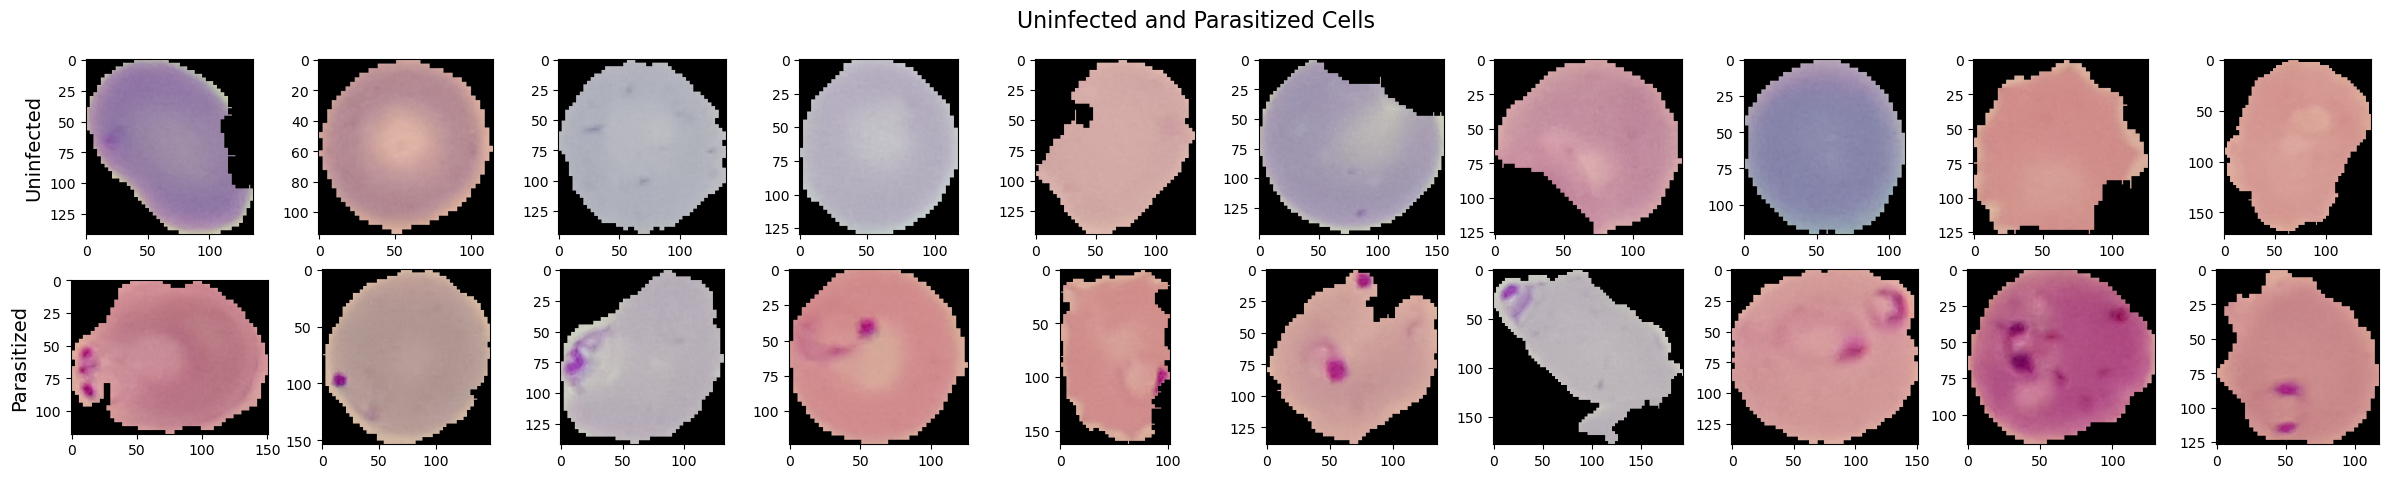

In [5]:
# select 10 random integers - we will use them to select images along this initial process
uninf_index = [randint(0, len(os.listdir(datapath[0]))) for _ in range(10)]
para_index = [randint(0, len(os.listdir(datapath[1]))) for _ in range(10)]
# plot the images
fig, ax = plt.subplots(2, 10, figsize=(30, 5))
fig.suptitle("Uninfected and Parasitized Cells", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs[uninf_index[i]])
    ax[1, i].imshow(para_imgs[para_index[i]])
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()


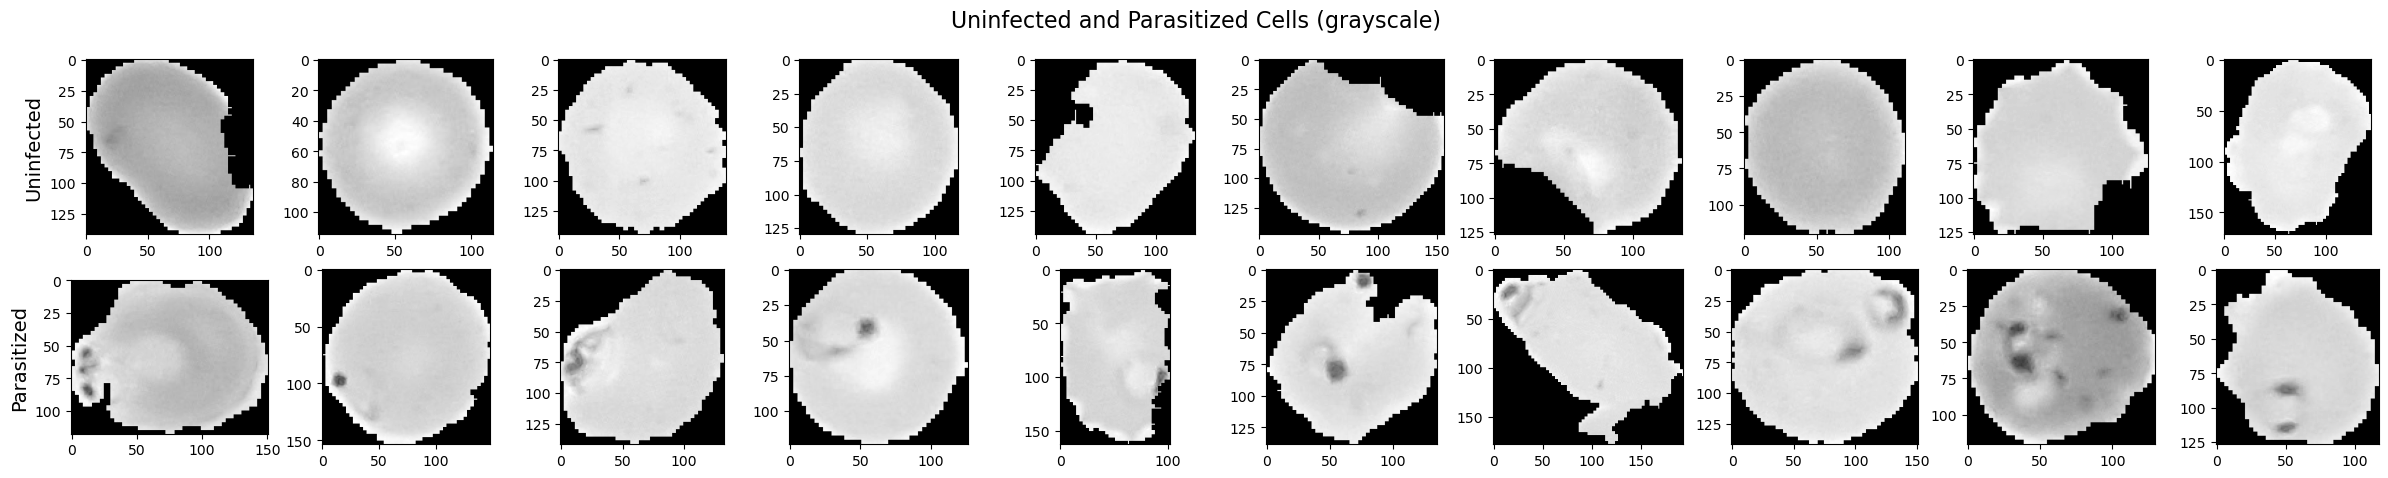

In [6]:
# plot the same images but in grayscale
fig, ax = plt.subplots(2, 10, figsize=(30, 5))
fig.suptitle("Uninfected and Parasitized Cells (grayscale)", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs_bw[uninf_index[i]], cmap="gray")
    ax[1, i].imshow(para_imgs_bw[para_index[i]], cmap="gray")
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()


> Dataset summary

Inspecting the images we can see that:

- Cells are of different shapes and sizes and that the infected cells have some visible violet spots.
- The morphology of the cells is not uniform and the violet spots are not always in the same place.
- The black borders presents in some images are not relevant and should be removed to avoid noise.
- Due to the fact that the color of the cells is not uniform, the violet spots could be more or less visible depending on the background color of the cell. Maybe the grayscale images will be more useful for the model.
- From the grayscale images we can see that the violet spots are darker than the rest of the cell and that the uninfected cells are lighter. This could be useful for the model, maybe with some preprocessing we can make the darker spots more visible.

We will use the grayscale images in the following steps, but we will keep the RGB images for future use.


In [7]:
# from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
# x_scaled = StandardScaler().fit_transform(x_train)
# x_minmax = MinMaxScaler().fit_transform(x_train)
# x_abs = MaxAbsScaler().fit_transform(x_train)
# x_robust = RobustScaler().fit_transform(x_train)
# x_scaled.min(), x_scaled.max(),x_scaled.mean(), x_scaled.std()
# x_minmax.min(), x_minmax.max(),x_minmax.mean(), x_minmax.std()
# x_robust.min(), x_robust.max(),x_robust.mean(), x_robust.std()
# x_stdminmax = RobustScaler().fit_transform(MinMaxScaler((0,255)).fit_transform(x_train))
# x_stdminmax.min(), x_stdminmax.max(),x_stdminmax.mean(), x_stdminmax.std()
# fig, ax = plt.subplots(1, 5, figsize=(20, 5))
# ax[0].imshow(x_scaled[15000].reshape(32,32), cmap='gray')
# ax[1].imshow(x_minmax[15000].reshape(32,32), cmap='gray')
# ax[3].imshow(x_robust[15000].reshape(32,32), cmap='gray')
# ax[4].imshow(x_stdminmax[15000].reshape(32,32), cmap='gray')

> Create data structures that will hold the images and their labels

We are going to preprocess the images in order to make them more suitable for the model. Using the grayscale images we will:

1. Remove black borders.
2. Resize the images to standardize the size.
3. (next) Standardize the images using sklearn.preprocessing scalers. We will cross-validate the best scaler for our model.


**Note:** This process is also useful to reduce computation time when training the model.


In [8]:
"""
    Preprocessing functions to transform an image to be used in the model.
    We will use other functions later like sklearn scalers.
"""


def remove_background(image):
    """Remove the black background of the image. The function takes the image and the threshold value. If the pixel is below the threshold, it is set to 0.
    Args:
        image (np.ndarray): image to be processed loaded with skimage.io.imread
    """
    img = image.copy()
    img[image == 0.0] = np.max(img)
    return img


def make_dataset(image, size=48):
    """Preprocessing function to transform an image to be used in the model. The steps are:
       1. Remove the black background
       2. Resize the image to the desired size
    We remove the black background before resizing the image to avoid having black borders in the resized image due to the interpolation maked by the resize function.
    The image is then flattened to be used in the model.
    Args:
        image (np.ndarray): image to be processed loaded with skimage.io.imread
        size (int): desired size of the image, the image will be resized to (size, size)
    """
    img = remove_background(image)
    img = resize(img, (size, size), anti_aliasing=True)
    return np.asarray(img).flatten()


In [9]:
# make a first preprocessing step to remove the black background and resize the images so that they have the same size and can be used as input for the model
with concurrent.futures.ProcessPoolExecutor() as executor:
    u = np.asarray(list(executor.map(make_dataset, uninf_imgs_bw)))
    p = np.asarray(list(executor.map(make_dataset, para_imgs_bw)))
del (
    datapath,
    label,
    labels,
    uninf_path,
    para_path,
    uninf_imgs,
    para_imgs,
    uninf_imgs_bw,
    para_imgs_bw,
    ax,
    fig,
    i,
    executor,
)
gc.collect()
# create matrix of features from the numpy vectors
X = np.concatenate((u, p))
# create matrix of labels from the numpy vectors length
y = np.concatenate((np.zeros(len(u)), np.ones(len(p)))).reshape(-1, 1)
# pandas dataframe
df = pd.DataFrame(data=X, columns=range(np.shape(X)[1])).merge(
    pd.DataFrame(data=y, columns=["labels"]), left_index=True, right_index=True
)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,labels
0,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,...,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.0
1,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,...,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.0
2,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,...,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.0
3,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,...,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.0
4,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,...,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.0


In [10]:
# store the dataframe in a csv file
# df.to_csv(os.path.join(root,"data.csv"), index=False)


Simple check on the distribution of the labels in the training and test sets. This will lead to see that our dataset is balanced.


Is the dataset balanced?  Yes


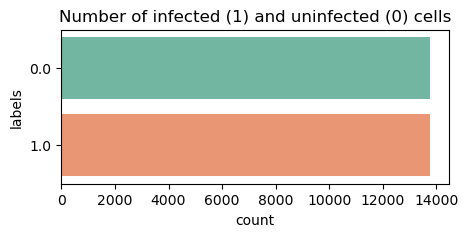

In [11]:
# Count the number of uninfected and infected cells
plt.figure(figsize=(5, 2), dpi=100)
plt.title("Number of infected (1) and uninfected (0) cells")
sns.countplot(y=df["labels"], palette="Set2")
print(
    "Is the dataset balanced? ",
    "Yes" if df["labels"].value_counts()[0] == df["labels"].value_counts()[1] else "No",
)


In [12]:
# def split_plot(
#    x: np.ndarray, index: int, label: str, plot: bool
# ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
#    """Split image into RGB channels and plot them"""
#    # convert vector into image to be splittable
#    r, g, b = Image.Image.split(vec2img(x[index]))
#    # treat each channel as a numpy array. No need to multiply values by 255 and cast to uint8
#    # because the image is already in uint8 format
#    npr = np.asarray(r)
#    npg = np.asarray(g)
#    npb = np.asarray(b)
#    np_img = (npr, npg, npb, x[index])
#    if plot:
#        [_, ax] = plt.subplots(1, 4, figsize=(5, 5), dpi=100)
#        cmaps = ["Reds", "Greens", "Blues"]
#        channels = ["Red", "Green", "Blue", "RGB"]
#        for _ in range(4):
#            ax[_].set_title(f"{label[0]} {channels[_]}")
#            if _ < 3:
#                ax[_].imshow(np_img[_], cmap=cmaps[_])
#            else:
#                ax[_].imshow(np_img[_])
#            ax[_].axis("off")
#    return np_img


> Split the dataset into Training and Test sets

- Training set: 70% of the dataset -> we will use this set to train the model after data augmentation
- Test set: 30% of the dataset -> we will use this set to test the model

_During the training phase we will use 5-Fold Cross Validation to evaluate the model and tune its hyperparameters._


In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training validation and test sets
test_ratio = 0.3
# now make two splits:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df.drop(columns=["labels"]),
    df["labels"],
    test_size=test_ratio,
    shuffle=True,
    stratify=y,
)


> Understanding model complexity

Using images, our dataset has a lot of features, so we will try to understand if model reduction techniques can help us. We will use PCA to reduce the dimensionality because we have only 2 classes and a supervised model is not necessary.

If the explained variance is not enough to explain the data, we need to use a more complex model. Probably a neural network.

_About LDA: we don't use LDA as a dimensionality reduction method because with just 2 classes the output of the reduction will have only 1 dimension._


> PCA


In [14]:
# Calculate the explained variance ratio to determine the number of components needed to explain 95% of the variance
# This result is reached with PCA(n_components=0.95). We insert the number of components here to avoid re-running the PCA solver.

#pca = PCA(n_components=135)
#pca.fit(X_train_val)
#fig = plt.figure(figsize=(10, 5))
#plt.suptitle("Cumulative Explained variance Ratio")
#plt.xlabel(f"Number of components - 95% at {pca.components_.shape[0]}")
#plt.ylabel("Variance(%)")
#plt.plot(
#    range(len(pca.explained_variance_ratio_)),
#    pca.explained_variance_ratio_.cumsum(),
#    "o-",
#    color="orange",
#)
#plt.axhline(y=0.95, color="black", linestyle="--")
#plt.axvline(x=pca.components_.shape[0], color="black", linestyle="--")
#plt.grid()
#del pca, fig
#gc.collect()
#

**Analysis:** Using 135 components we can explain 95% of the variance, so we can use this number as a threshold to reduce the dimensionality of the dataset from 4096 to 135.


> Classification tests

We will use simple models to test the dataset and to understand if we can get a good accuracy with a simple model. Then we will try to optimize the best scoring model searching for the best hyperparameters.

_Pipelines will be used to simplify the preprocessing steps in order to make more tests with different initial parameters._

**Linear Support Vector (Machine) Classification:** supervised learning model for classification. It's an optimized implementation of the Support Vector Machine algorithm for the case of a linear kernel. It is useful in high dimensional spaces like images.

**K-Nearest Neighbors:** supervised learning algorithm based on the k-nearest neighbors principle. it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

**Random Forest:** supervised learning algorithm. It creates a set of decision trees from a randomly selected subset of the training set. It then aggregates the votes from different decision trees to decide the final class of the test object.

**Gradient Boosting:** supervised learning algorithm. It produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

\*\*A

**Logistic Regression:** supervised learning algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. It is a special case of linear regression where the dependent variable is categorical in nature. It is used to estimate the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick.

_(From the scikit-learn documentation)_


In [15]:
# Prepare the data for the model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
robust_scale = RobustScaler()
std_scale = StandardScaler()

{'scaler': 'RobustScaler',
'Robust_unit_variance': False,
'dim_reduction': 'None',
'feat_select': 'LinearSVC',
'C_select': 0.0002141776028033699,
'C_model': 0.00010855566958877752,
'folds': 10}


In [26]:
# Let's try without feature reduction
x_robust = robust_scale.fit_transform(X_train_val)
x_std = std_scale.fit_transform(X_train_val)
x_test_robust = robust_scale.transform(X_test)
x_test_std = std_scale.transform(X_test)

In [27]:
from sklearn.svm import LinearSVC
# We use LinearSVC because it is faster than SVC(kernel="linear") and it is more efficient in high dimensional spaces. The dual formulations is disabled because the number of samples is greater than the number of features.
svc = LinearSVC(dual=False, max_iter=10000)
svc.fit(x_robust, y_train_val)
score = svc.score(x_test_robust, y_test)
print(f"LinearSVC (Robust Scaling) baseline Accuracy: {score}")
svc.fit(x_std, y_train_val)
score = svc.score(x_test_std, y_test)
print(f"LinearSVC (Standard Scaling) baseline Accuracy: {score}")


LinearSVC (Robust Scaling) baseline Accuracy: 0.6545718432510885
LinearSVC (Standard Scaling) baseline Accuracy: 0.6539671020803096


LinearSVC seems to works well when the features are scaled by the RobustScaler, which is more robust to outliers because it uses the median and the interquartile range instead of the mean and the standard deviation.


In [28]:
# Let's try adding PCA to the pipeline
pca_robust = PCA(n_components=0.95)
pca_std = PCA(n_components=0.95)
robust_pipeline = make_pipeline(robust_scale, pca_robust, svc)
score = robust_pipeline.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"LinearSVC (Robust Scaling - PCA) baseline Accuracy: {score}")
std_pipeline = make_pipeline(std_scale, pca_std, svc)
score = std_pipeline.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"LinearSVC (Standard Scaling - PCA) baseline Accuracy: {score}")


LinearSVC (Robust Scaling - PCA) baseline Accuracy: 0.6819061441702952
LinearSVC (Standard Scaling - PCA) baseline Accuracy: 0.6826318335752298


In [29]:
pca_std.n_components_, pca_robust.n_components_

(115, 115)

Seems that PCA is useful to augment the performance of the models. We will use it by default in the following steps.


In [30]:
x_robust = pca_robust.transform(x_robust)
x_std = pca_std.transform(x_std)
x_test_robust = pca_robust.transform(x_test_robust)
x_test_std = pca_std.transform(x_test_std)

{'scaler': 'StandardScaler', 'dim_reduction': 'PCA', 'whiten': True, 'feat_select': 'SelectKBest', 'score_func': 'f_classif', 'k': 100, 'n_neighbors': 2, 'weights': 'distance', 'folds': 5}


In [31]:
# Try with K-Nearst Neighbors
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, weights="distance")
robust_pipeline = make_pipeline(robust_scale, pca_robust, knc)
score = robust_pipeline.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"KNC (Robust Scaling - PCA) baseline Accuracy: {score}")
std_pipeline = make_pipeline(std_scale, pca_std, knc)
score = std_pipeline.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"KNC (Standard Scaling - PCA) baseline Accuracy: {score}")

KNC (Robust Scaling - PCA) baseline Accuracy: 0.8656265118529269
KNC (Standard Scaling - PCA) baseline Accuracy: 0.8538945331398161


KNC accuracy is low, just a 10% higher than the simple guess, optimized it will not improve the result too much.


In [32]:
# Try with Logistic Regression
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(max_iter=10000, n_jobs=-1)
robust_pipeline = make_pipeline(robust_scale, pca_robust, lrc)
score = robust_pipeline.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"LRC (Robust Scaling - PCA) baseline Accuracy: {score}")
std_pipeline = make_pipeline(std_scale, pca_std, lrc)
score = std_pipeline.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"LRC (Standard Scaling - PCA) baseline Accuracy: {score}")

LRC (Robust Scaling - PCA) baseline Accuracy: 0.6444121915820029
LRC (Standard Scaling - PCA) baseline Accuracy: 0.6513062409288825


In [33]:
# Try with AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
robust_pipeline = make_pipeline(robust_scale, pca_robust, abc)
score = robust_pipeline.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"ABC (Robust Scaling - PCA) baseline Accuracy: {score}")
std_pipeline = make_pipeline(std_scale, pca_std, lrc)
score = std_pipeline.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"ABC (Standard Scaling - PCA) baseline Accuracy: {score}")

ABC (Robust Scaling - PCA) baseline Accuracy: 0.8999758103531689
ABC (Standard Scaling - PCA) baseline Accuracy: 0.6513062409288825


In [34]:
# Try with Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1)
robust_pipeline = make_pipeline(robust_scale, pca_robust, abc)
score = robust_pipeline.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"GBC (Robust Scaling - PCA) baseline Accuracy: {score}")
std_pipeline = make_pipeline(std_scale, pca_std, lrc)
score = std_pipeline.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"GBC (Standard Scaling - PCA) baseline Accuracy: {score}")

GBC (Robust Scaling - PCA) baseline Accuracy: 0.8999758103531689
GBC (Standard Scaling - PCA) baseline Accuracy: 0.6513062409288825


In [35]:
# Let's try adding a random forest classifier with and without bootstrapping
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=30, criterion="entropy")
rfc_bootstrap = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=30, criterion="entropy", bootstrap=True)
robust_pipeline = make_pipeline(robust_scale, pca_robust, rfc)
score = robust_pipeline.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"RFC (Robust Scaling - PCA) baseline Accuracy: {score}")
robust_pipeline_bootstrap = make_pipeline(robust_scale, pca_robust, rfc_bootstrap)
score = robust_pipeline_bootstrap.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"RFC (Robust Scaling - PCA - bootstrap) baseline Accuracy: {score}")
std_pipeline = make_pipeline(std_scale, pca_std, rfc)
score = std_pipeline.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"RFC (Standard Scaling - PCA) baseline Accuracy: {score}")
std_pipeline_bootstrap = make_pipeline(std_scale, pca_std, rfc_bootstrap)
score = std_pipeline_bootstrap.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"RFC (Standard Scaling - PCA - bootstrap) baseline Accuracy: {score}")

RFC (Robust Scaling - PCA) baseline Accuracy: 0.9037252056119981
RFC (Robust Scaling - PCA - bootstrap) baseline Accuracy: 0.9062651185292695
RFC (Standard Scaling - PCA) baseline Accuracy: 0.8991291727140783
RFC (Standard Scaling - PCA - bootstrap) baseline Accuracy: 0.8994920174165457


In [36]:
# Try with Histogram-based Gradient Boosting Classifier
from sklearn.ensemble import HistGradientBoostingClassifier
hgbc = HistGradientBoostingClassifier(max_iter=500, max_depth=30, learning_rate=0.1)
robust_pipeline = make_pipeline(robust_scale, pca_robust, hgbc)
score = robust_pipeline.fit(x_robust, y_train_val).score(x_test_robust, y_test)
print(f"HGBC (Robust Scaling - PCA) baseline Accuracy: {score}")
std_pipeline = make_pipeline(std_scale, pca_std, hgbc)
score = std_pipeline.fit(x_std, y_train_val).score(x_test_std, y_test)
print(f"HGBC (Standard Scaling - PCA) baseline Accuracy: {score}")

HGBC (Robust Scaling - PCA) baseline Accuracy: 0.9161828737300436
HGBC (Standard Scaling - PCA) baseline Accuracy: 0.9154571843251088


In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# -- Make a function to print out mean accuracy scores for both train and test sets
# and to get a dataframe for precision, recall, and f1 scores for each class
def get_scores(pipeline, tuning_method):
    # -- Get scores for training data
    kfold = StratifiedKFold(5, shuffle=True)
    score = cross_val_score(pipeline, X_train_val, y_train_val, scoring="accuracy", cv=kfold, n_jobs=-1)
    print(
        "Training set: %0.2f mean accuracy with a standard deviation of %0.2f"
        % (score.mean(), score.std())
    )

    # -- Fit the tuned model
    pipeline.fit(X_train_val, y_train_val)

    # -- Evaluate on the test set
    # (a) mean accuracy
    test_score = pipeline.score(X_test, y_test)
    print("Testing set: %0.2f mean accuracy" % test_score)
    # (b) predict the labels for test data
    y_predicted = pipeline.predict(X_test)
    
    print("Classification report for the testing set:")
    print(classification_report(y_test, y_predicted))

    # -- Produce a dataframe of all metrics for all classes for the model
    # (a) Get scores for each metric for all classes
    scores = classification_report(y_test, y_predicted, output_dict=True)

    # Since the output is a dictionary of various metrics and we only need information on each class
    # we need to extract this information and store it as a dataframe for when we plot it
    # (b) Get a list of dataframes corresponsing to each class from the scores dictionary
    list_of_dfs = []
    for class_number in range(0, 1):
        # -- Define columns
        each_score = list(scores[str(float(class_number))].values())[
            :-1
        ]  # get all values into a list apart from the last value (which is support)
        metric = list(scores[str(float(class_number))].keys())[
            :-1
        ]  # do the same for keys
        class_name = list(
            str(class_number) * 3
        )  # assign the class to which the three metrics belong to
        tuning = [
            tuning_method for i in range(3)
        ]  # mark which tuning method these metrics belong to

        data = list(zip(each_score, metric, class_name, tuning))

        # -- Make a dataframe for each class
        scores_df = pd.DataFrame(
            data=data, columns=["score", "metric", "class", "tuning method"]
        )

        # -- Make a list of all dataframes
        list_of_dfs.append(scores_df)

    # -- Concatenate all class dataframes
    class_scores = pd.concat(list_of_dfs)

    return class_scores


In [43]:
scores_df = get_scores(robust_pipeline, "Accuracy")

Training set: 0.92 mean accuracy with a standard deviation of 0.00
Testing set: 0.92 mean accuracy
Classification report for the testing set:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      4134
         1.0       0.91      0.94      0.92      4134

    accuracy                           0.92      8268
   macro avg       0.92      0.92      0.92      8268
weighted avg       0.92      0.92      0.92      8268



Ensemble methods seems to be the better models to use with this dataset. We will make optimizations on them and we will use the better as baseline comparison with the CNN

{'scaler': 'StandardScaler', 'dim_reduction': 'PCA', 'whiten': False, 'feat_select': 'SelectKBest', 'score_func': 'f_classif', 'k': 100, 'n_estimators_model': 700, 'max_depth': 40, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 6, 'bootstrap_model': False, 'folds': 5}


In [87]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    f_classif,
    mutual_info_classif,
)
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


def objective(trial, X, y):
    # define possible scalers    
    scaler = RobustScaler(unit_variance=trial.suggest_categorical("Robust_unit_variance", [True, False]))
    # define possible PCA
    dim_reduction = trial.suggest_categorical("dim_reduction", ["PCA", "None"])
    if dim_reduction == "PCA":        
        dim_reduction_algo = PCA(n_components = 0.95,
                                 whiten=trial.suggest_categorical("whiten", [True, False]))
    else:
        dim_reduction_algo = "passthrough"
    # define feature selection
    feat_select = trial.suggest_categorical(
        "feat_select", ["SelectKBest","LinearSVC", "None"]
    )
    if feat_select == "SelectKBest":
        score_func = trial.suggest_categorical(
            "score_func", ["f_classif", "mutual_info_classif"]
        )
        if score_func == "f_classif":
            score_func = f_classif
        else:
            score_func = mutual_info_classif
        feat_selector = SelectKBest(
            score_func = score_func, 
            k = 'all'
        )    
    elif feat_select == "LinearSVC":
        feat_selector = SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("C_select", 1e-4, 1e-2, log=True),
                max_iter = 10000,
                dual = False,
                penalty=trial.suggest_categorical("penalty", ["l1", "l2"])
            ),
            norm_order=trial.suggest_int("norm_order", 1, 2)
        )
    else:
        feat_selector = "passthrough"
    # define the model
    estimator = HistGradientBoostingClassifier(        
        learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        max_iter = trial.suggest_int("max_iter", 100, 500, step=100),
        max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 80, 100, step=1),
        max_depth = trial.suggest_int("max_depth", 400, 500, step=10),
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 30, step=2),
        l2_regularization = trial.suggest_float("l2_regularization", 1e-5, 1e-4),        
        class_weight='balanced'           
    )
    # instantiate the cross validation object
    skf = StratifiedKFold(n_splits=trial.suggest_int("folds", 5,10,step=1), shuffle=True)
    # define the preprocessing pipeline
    pipeline = make_pipeline(scaler, dim_reduction_algo, feat_selector, estimator)
    score = cross_val_score(pipeline, X, y, scoring="accuracy", n_jobs=-1, cv=skf)
    f1 = score.mean()  # calculate the mean of scores
    return f1

In [88]:
# define the parameters for the SVC model
J = lambda trial: objective(trial, X_train_val, y_train_val)
study = optuna.create_study(direction="maximize")

[I 2023-03-07 22:13:43,903] A new study created in memory with name: no-name-3e8ed56d-bec6-4701-8982-033a5232de3f


{'Robust_unit_variance': False,
 'dim_reduction': 'None',
 'feat_select': 'None',
 'learning_rate': 0.05560531812360735,
 'max_iter': 300,
 'max_leaf_nodes': 85,
 'max_depth': 430,
 'min_samples_leaf': 20,
 'l2_regularization': 4.516561664191977e-05,
 'folds': 10}

In [93]:
#study.optimize(J, n_trials=50)

[I 2023-03-08 00:27:54,215] Trial 20 finished with value: 0.926231361339301 and parameters: {'Robust_unit_variance': False, 'dim_reduction': 'None', 'feat_select': 'None', 'learning_rate': 0.07389134797279658, 'max_iter': 200, 'max_leaf_nodes': 94, 'max_depth': 500, 'min_samples_leaf': 24, 'l2_regularization': 1.6407170472844876e-05, 'folds': 8}. Best is trial 18 with value: 0.9286670993160837.
[I 2023-03-08 00:37:42,957] Trial 21 finished with value: 0.9278899940708458 and parameters: {'Robust_unit_variance': False, 'dim_reduction': 'None', 'feat_select': 'None', 'learning_rate': 0.07697740102426313, 'max_iter': 200, 'max_leaf_nodes': 94, 'max_depth': 500, 'min_samples_leaf': 24, 'l2_regularization': 1.7959060295131394e-05, 'folds': 8}. Best is trial 18 with value: 0.9286670993160837.
[I 2023-03-08 00:45:50,490] Trial 22 finished with value: 0.9278903492152131 and parameters: {'Robust_unit_variance': False, 'dim_reduction': 'None', 'feat_select': 'None', 'learning_rate': 0.08010787165

{'scaler': 'RobustScaler',
'Robust_unit_variance': True,
'dim_reduction': 'None',
'feat_select': 'None',
'learning_rate': 0.07255819187512555,
'max_iter': 200,
'max_leaf_nodes': 83,
'max_depth': 460,
'min_samples_leaf': 26,
'l2_regularization': 1.163954991164277e-05,
'class_weight': 'balanced',
'folds': 10}


In [55]:
#study.optimize(J, n_trials=100)

[I 2023-03-06 20:58:01,629] Trial 0 finished with value: 0.9002592016588906 and parameters: {'scaler': 'StandardScaler', 'dim_reduction': 'None', 'feat_select': 'ExtraTreesClassifier', 'n_estimators': 600, 'bootstrap_select': False, 'learning_rate': 0.006729192556397861, 'max_iter': 1000, 'max_leaf_nodes': 43, 'max_depth': 350, 'min_samples_leaf': 26, 'l2_regularization': 2.0791441528918442e-05, 'class_weight': 'balanced', 'folds': 5}. Best is trial 0 with value: 0.9002592016588906.
[I 2023-03-06 21:07:01,016] Trial 1 finished with value: 0.9221876620010369 and parameters: {'scaler': 'RobustScaler', 'Robust_unit_variance': True, 'dim_reduction': 'None', 'feat_select': 'None', 'learning_rate': 0.03682780956895103, 'max_iter': 800, 'max_leaf_nodes': 42, 'max_depth': 220, 'min_samples_leaf': 32, 'l2_regularization': 5.582838690503278e-06, 'class_weight': None, 'folds': 5}. Best is trial 1 with value: 0.9221876620010369.
[I 2023-03-06 21:27:08,698] Trial 2 finished with value: 0.8420943494

In [96]:
print("%0.5f" %  4.516561664191977e-05)

0.00005


In [94]:
study.best_params

{'Robust_unit_variance': False,
 'dim_reduction': 'None',
 'feat_select': 'None',
 'learning_rate': 0.05560531812360735,
 'max_iter': 300,
 'max_leaf_nodes': 85,
 'max_depth': 430,
 'min_samples_leaf': 20,
 'l2_regularization': 4.516561664191977e-05,
 'folds': 10}

In [78]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.drop(columns=["labels"]),
    df["labels"],
    test_size=0.7,
    shuffle=True,
    stratify=y)

In [79]:
pipeline = make_pipeline(
    RobustScaler(unit_variance=True),
    HistGradientBoostingClassifier(
        learning_rate=0.073,
        max_iter=200,
        max_leaf_nodes=83,
        max_depth=460,
        min_samples_leaf=26,
        l2_regularization=1e-5,
        class_weight="balanced",
    )
)


0.9104245503084339

In [105]:
pipeline.fit(X_train_val, y_train_val)

Pipeline(steps=[('robustscaler', RobustScaler(unit_variance=True)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=1e-05,
                                                learning_rate=0.073,
                                                max_depth=460, max_iter=200,
                                                max_leaf_nodes=83,
                                                min_samples_leaf=26))])

In [106]:
pipeline.score(X_train_val, y_train_val)

0.9914463452566097

In [107]:
pipeline.score(X_test, y_test)

0.9296081277213353

In [97]:
pipeline2 = make_pipeline(
    RobustScaler(),
    HistGradientBoostingClassifier(
        learning_rate=0.057,
        max_iter=300,
        max_leaf_nodes=85,
        min_samples_leaf=20,        
        l2_regularization=4.5e-5,
        class_weight="balanced",
        max_depth=430
    )
)
        

In [102]:
fitted = pipeline2.fit(X_train_val, y_train_val)

In [103]:
fitted.score(X_train_val, y_train_val)

0.9931570762052877

In [104]:
fitted.score(X_test, y_test)

0.933599419448476

In [74]:
y_test[:10]

26930    1.0
17426    1.0
961      0.0
16652    1.0
17775    1.0
2213     0.0
4431     0.0
1610     0.0
21796    1.0
18780    1.0
Name: labels, dtype: float64

In [73]:
pipeline.predict(X_test[:10])

array([1., 1., 0., 1., 1., 0., 0., 0., 1., 0.])

In [57]:
optuna.visualization.plot_optimization_history(study)

In [108]:
optuna.visualization.plot_param_importances(study)

In [28]:
study.best_params

{'scaler': 'RobustScaler',
 'Robust_unit_variance': False,
 'dim_reduction': 'None',
 'feat_select': 'LinearSVC',
 'C_select': 0.0002141776028033699,
 'C_model': 0.00010855566958877752,
 'folds': 10}

In [35]:
J = lambda trial: objective(trial, "RandomForestClassifier", X_train_val, y_train_val)
study.optimize(J, n_trials=100)

/home/effi/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/effi/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/effi/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default v

In [36]:
optuna.visualization.plot_optimization_history(study)

In [37]:
optuna.visualization.plot_param_importances(study)

In [38]:
J = lambda trial: objective(trial, "KNeighborsClassifier", X_train_val, y_train_val)
study.optimize(J, n_trials=100)

[I 2023-03-05 12:26:37,461] Trial 200 finished with value: 0.7544960608170871 and parameters: {'scaler': 'StandardScaler', 'dim_reduction': 'PCA', 'whiten': True, 'feat_select': 'SelectKBest', 'score_func': 'f_classif', 'k': 100, 'n_neighbors': 10, 'weights': 'distance', 'folds': 5}. Best is trial 155 with value: 0.9095398688261092.
[I 2023-03-05 12:27:54,385] Trial 201 finished with value: 0.7558882318747765 and parameters: {'scaler': 'StandardScaler', 'dim_reduction': 'PCA', 'whiten': True, 'feat_select': 'SelectKBest', 'score_func': 'f_classif', 'k': 100, 'n_neighbors': 2, 'weights': 'uniform', 'folds': 5}. Best is trial 155 with value: 0.9095398688261092.
[I 2023-03-05 12:29:09,731] Trial 202 finished with value: 0.795695585280433 and parameters: {'scaler': 'StandardScaler', 'dim_reduction': 'PCA', 'whiten': True, 'feat_select': 'SelectKBest', 'score_func': 'f_classif', 'k': 100, 'n_neighbors': 6, 'weights': 'distance', 'folds': 5}. Best is trial 155 with value: 0.9095398688261092.

In [39]:
optuna.visualization.plot_optimization_history(study)

In [41]:
trials = study.get_trials()

In [42]:
trials

In [40]:
optuna.visualization.plot_param_importances(study)

{'scaler': 'RobustScaler',
'Robust_unit_variance': False,
'dim_reduction': 'None',
'feat_select': 'LinearSVC',
'C_select': 0.0002141776028033699,
'C_model': 0.00010855566958877752,
'folds': 10}


In [34]:
# -- Plot the scores for each class with LinearSVC model
pipe = make_pipeline(
    RobustScaler(unit_variance=False),
    #PCA(n_components=0.95, whiten=False),
    SelectFromModel(LinearSVC(C=2e-4, class_weight='balanced', dual=False, max_iter=10000)),
    LinearSVC(C = 1e-4, class_weight = 'balanced', max_iter = 10000, dual=False)
)
score = get_scores(pipe, "LinearSVC")

Training set: 0.67 mean accuracy with a standard deviation of 0.01
Testing set: 0.69 mean accuracy

Classification report for the testing set:
              precision    recall  f1-score   support

         0.0       0.68      0.74      0.71      4134
         1.0       0.72      0.64      0.68      4134

    accuracy                           0.69      8268
   macro avg       0.70      0.69      0.69      8268
weighted avg       0.70      0.69      0.69      8268



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

model = KNeighborsClassifier(
    n_neighbors=5, n_jobs=-1, metric="euclidean", weights="distance"
)

In [ ]:
from asyncio.windows_utils import pipe
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import optuna
from keras.preprocessing.image import ImageDataGenerator


# create a function to train and test the model
def classifier(X, y, model, folds):
    # create a K-fold object
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    fitted_model = model
    # create empty lists to store training and prediction the results
    y_true, y_pred = list(), list()
    # loop over the folds, splitting the data into training and testing sets
    for train_index, val_index in skf.split(X, y):
        # split the data into training and testing sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # train the model
        fitted_model.fit(X_train, y_train)
        # evaluate the model on the test set
        y_hat = fitted_model.predict(X_val)
        # store the results
        y_true = np.concatenate((y_true, y_val), axis=0)
        y_pred = np.concatenate((y_pred, y_hat), axis=0)
    # evaluate the accuracy of the model -> todo: add metrics
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy: %.7f" % acc)
    print(f"Confusion Matrix: {confusion_matrix(y_true, y_pred)}")
    return fitted_model


# create a class to optimize the hyperparameters of the model
class classifier_obj:
    def __init__(self, X: np.ndarray, y: np.ndarray, model_name: str):
        # store the data and model
        self.X = X
        self.y = y
        self.model_name = model_name
        self.model = None
        # create a K-fold object
        self.skf = None
        # create empty lists to store training and prediction the results
        self.y_true, self.y_pred = list(), list()
        # Optuna parameters dictionary and trial object
        self.params = {}

    def get_model(self):
        return self.model

    def set_cross_validator(self, folds: int):
        self.skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    def get_cross_validator(self):
        return self.skf

    def objective(self, trial: optuna.trial.Trial, scaler: str, score: str):
        # define the scaler object
        scalers = trial.suggest_categorical("scalers", ["minmax", "standard", "robust"])
        if scalers == "minmax":
            scaler = MinMaxScaler()
        elif scalers == "standard":
            scaler = StandardScaler()
        else:
            scaler = RobustScaler()
        # istantiate dimensionality reduction object
        dim_red = trial.suggest_categorical("dim_red", ["PCA", None])
        if dim_red == "PCA":
            n_components = trial.suggest_int("n_components", 10, 15)
            dim_red_obj = PCA(n_components=n_components)
        if self.model_name == "KNC":
            n_neighbors = trial.suggest_int("n_neighbors", 1, 19, 2)
            metric = trial.suggest_categorical(
                "metric", ["euclidean", "manhattan", "minkowski"]
            )
            weights = trial.suggest_categorical("weights", ["uniform", "distance"])
            self.params = {
                "n_neighbors": n_neighbors,
                "metric": metric,
                "weights": weights,
            }
            self.model = KNeighborsClassifier(**self.params)

        pipeline = make_pipeline()

> We are making some test with raw hyperparameters

We will use some default hyperparameters and see how the model performs. Then we will try to tune the hyperparameters to improve the model that will score the best on the test set.


da


In [ ]:
model = classifier(
    X_train_val.values, y_train_val.values, KNeighborsClassifier(n_neighbors=5), 5
)
y_pred = model.predict(X_test.values)
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy on test set: %.7f" % accuracy)
print(f"Confusion Matrix: {confusion_matrix(y_test.values, y_pred)}")


We can see that this model is not performing well: using the default hyperparameters we get an accuracy of 60% on the validation and the test set. This means that we are near to the baseline accuracy of 50% (random guessing).

Let's see how the other models perform.


In [ ]:
# Random Forest
model = classifier(
    X_train_val.values,
    y_train_val.values,
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    5,
)
y_pred = model.predict(X_test.values)
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy on test set: %.7f" % accuracy)
print(f"Confusion Matrix: {confusion_matrix(y_test.values, y_pred)}")


In [ ]:
# Support Vetor Machine - Linear
# TODO: - make SGDClassifier with Kernel Approximation Nyström
model = classifier(
    X=X_train_val.values,
    y=y_train_val.values,
    model=LinearSVC(
        C=1.0e-3, max_iter=10000, class_weight="balanced", random_state=42, tol=1e-5
    ),
    folds=5,
)
y_pred = model.predict(X_test.values)
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy on test set: %.7f" % accuracy)
print(f"Confusion Matrix: {confusion_matrix(y_test.values, y_pred)}")

In [ ]:
study = optuna.create_study(direction="maximize", study_name="Image_Analysis")


In [ ]:
func = lambda trial: objective_KNC(
    trial, X_train_val, y_train_val.values.ravel(), KNeighborsClassifier, "KNC"
)
# study.optimize(func, n_trials=100)


> Perform data augmentation

To improve the model performance, we will perform data augmentation on the training set. We will use the following transformations:

- Rotation
- Zoom
- Horizontal and Vertical Flips
- Width and Height Shifts
- Shear Transformation
- Brightness
- Contrast
- Gaussian Noise
- Gaussian Blur
- Motion Blur
- Median Blur
- Random Crop
- To Gray
- Coarse Dropout
- Invert


In [ ]:
# we will use the Keras ImageDataGenerator to augment the data
from keras.preprocessing.image import ImageDataGenerator

# create an instance of the ImageDataGenerator
datagen = ImageDataGenerator()
# fit the generator to the data - this will calculate the mean and std of the data
datagen.fit(X_train)
# get a batch iterator to efficiently iterate over the training data
train_iterator = datagen.flow(X_train, y_train, batch_size=32)
# get a batch iterator for the validation data
val_iterator = datagen.flow(X_val, y_val, batch_size=32)
# fit the model
mod


> [Histograms of Oriented Gradients (HOG)](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)

is a feature extraction technique used in image analysis to identify and recognize objects in an image. The HOG technique describes the local appearance of an image in terms of the distribution of the intensity gradients' orientations.

We will use the HOG technique to extract features from the images and use them as input for the model and see if we can get better results.


Create a function to normalize the images and convert them to numpy arrays.
We want to center the data around the mean and scale it to unit variance. This is done by subtracting the mean and dividing by the standard deviation.


In [ ]:
def normalize_by_channel(X: np.ndarray) -> np.ndarray:
    """Center and scale the data to have zero mean and unit variance.
    The result is obtained by subtracting the mean and dividing by the standard deviation.
    We do this for each channel of the image, then we merge the channels back together.
    Args:
        X (np.ndarray): Matrix of features to be normalized

    Returns:
        np.ndarray: Matrix of normalized features
    """
    # initialize the list of normalized images
    norm_imgs = []
    # loop over each row in X
    for entry in X:
        # convert the vector to an image and split it into RGB channels
        r, g, b = Image.Image.split(vec2img(entry))
        # convert the channels to numpy arrays to perform the normalization
        npr = np.asarray(r).astype(np.uint8)
        npg = np.asarray(g).astype(np.uint8)
        npb = np.asarray(b).astype(np.uint8)
        # find the mean and standard deviation of each channel
        r_norm = (npr - np.mean(npr)) / np.std(npr)


> Construct the dataset matrices X and y


> Visualize some data informations


> Extract features from images with PCA analysis


> Define generical wrapper function to be able to change models
